In [489]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

%matplotlib inline

In [490]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [491]:
import pandas as pd

#Read input data
df_train = pd.read_csv('/content/drive/MyDrive/ML/titanic-ml-project/data/raw/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ML/titanic-ml-project/data/raw/test.csv')

df_gender_submission = pd.read_csv('/content/drive/MyDrive/ML/titanic-ml-project/data/raw/gender_submission.csv')
df_test = pd.merge(df_test, df_gender_submission, on='PassengerId', how='inner')

df_train['Data_Split'] = 'train'
df_test['Data_Split'] = 'test'
df = pd.concat([df_train, df_test])

### Feature Engineering

In [492]:
#Creating new family_size column
df['Family_Size']=df['SibSp']+df['Parch']
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Data_Split,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test,0
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test,0
415,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test,0
416,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test,0


In [493]:
df['Fare_Per_Person']=round(df['Fare']/(df['Family_Size']+1), 1)


In [494]:
# Replace NaN with 0 and other values with 1
df['Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

print(df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
413         1305         0       3   
414         1306         1       1   
415         1307         0       3   
416         1308         0       3   
417         1309         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [495]:
value_counts = df['Cabin'].value_counts()
print(value_counts)

Cabin
0    1014
1     295
Name: count, dtype: int64


In [496]:
# Dropping columns
columns_to_drop = ['Name','SibSp','Fare','PassengerId','Ticket', 'Parch']
df = df.drop(columns=columns_to_drop)
df

,Survived,Pclass,Sex,Age,Cabin,Embarked,Data_Split,Family_Size,Fare_Per_Person
0,0,3,male,22.0,0,S,train,1,3.6
1,1,1,female,38.0,1,C,train,1,35.6
2,1,3,female,26.0,0,S,train,0,7.9
3,1,1,female,35.0,1,S,train,1,26.6
4,0,3,male,35.0,0,S,train,0,8.0
...,...,...,...,...,...,...,...,...,...
413,0,3,male,NaN,0,S,test,0,8.0
414,1,1,female,39.0,1,C,test,0,108.9
415,0,3,male,38.5,0,S,test,0,7.2
416,0,3,male,NaN,0,S,test,0,8.0


In [497]:
# Check the data types
print(df.dtypes)

Survived             int64
Pclass               int64
Sex                 object
Age                float64
Cabin                int64
Embarked            object
Data_Split          object
Family_Size          int64
Fare_Per_Person    float64
dtype: object


#### Data Split

In [498]:
# Split the data
train_data = df[df['Data_Split'] == 'train']
test_data = df[df['Data_Split'] == 'test']

### More Feature Ing.

In [499]:
value_counts = train_data['Family_Size'].value_counts()
print(value_counts)

Family_Size
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: count, dtype: int64


   Family_Size  Survival Rate
3            3       0.724138
2            2       0.578431
1            1       0.552795
6            6       0.333333
0            0       0.303538
4            4       0.200000
5            5       0.136364
7            7       0.000000
8           10       0.000000


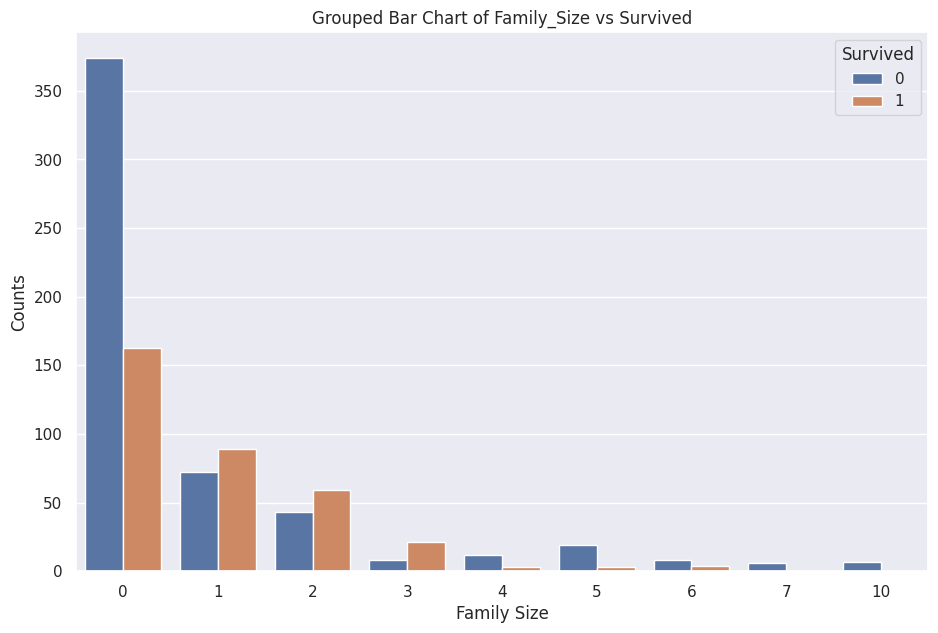

In [500]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each combination of Family_Size and Survived
count_train_data = train_data.groupby(['Family_Size', 'Survived']).size().reset_index(name='Counts')

# Calculate total passengers by Family Size
total_passengers = count_train_data.groupby('Family_Size')['Counts'].sum().reset_index(name='Total')

# Merge to get total passengers with the counts of survivors
merged_train_data = pd.merge(count_train_data, total_passengers, on='Family_Size')

# Calculate the number of survivors
merged_train_data['Survivors'] = merged_train_data['Counts'].where(merged_train_data['Survived'] == 1, 0)

# Calculate survival rate
survival_rate = merged_train_data.groupby('Family_Size').agg({'Survivors': 'sum', 'Total': 'first'}).reset_index()
survival_rate['Survival Rate'] = survival_rate['Survivors'] / survival_rate['Total']

# Sort the survival_rate DataFrame by Survival Rate in descending order
sorted_survival_rate = survival_rate.sort_values(by='Survival Rate', ascending=False)

# Print the sorted survival rates
print(sorted_survival_rate[['Family_Size', 'Survival Rate']])

# Plotting the grouped bar chart
sns.barplot(x='Family_Size', y='Counts', hue='Survived', data=count_train_data)
plt.title('Grouped Bar Chart of Family_Size vs Survived')
plt.xlabel('Family Size')
plt.ylabel('Counts')
plt.show()


In [501]:
# Calculate the mean of the target variable for each category
mean_target = train_data.groupby('Family_Size')['Survived'].mean()

# Map the encoded values back to the DataFrame
train_data['Family_Size_Encoded'] = train_data['Family_Size'].map(mean_target)

train_data = train_data.drop('Family_Size', axis=1)
train_data

/tmp/ipython-input-3350957447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Family_Size_Encoded'] = train_data['Family_Size'].map(mean_target)


,Survived,Pclass,Sex,Age,Cabin,Embarked,Data_Split,Fare_Per_Person,Family_Size_Encoded
0,0,3,male,22.0,0,S,train,3.6,0.552795
1,1,1,female,38.0,1,C,train,35.6,0.552795
2,1,3,female,26.0,0,S,train,7.9,0.303538
3,1,1,female,35.0,1,S,train,26.6,0.552795
4,0,3,male,35.0,0,S,train,8.0,0.303538
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,S,train,13.0,0.303538
887,1,1,female,19.0,1,S,train,30.0,0.303538
888,0,3,female,NaN,0,S,train,5.9,0.724138
889,1,1,male,26.0,1,C,train,30.0,0.303538


In [502]:
# Calculate the mean of the target variable for each category
mean_target = test_data.groupby('Family_Size')['Survived'].mean()

# Map the encoded values back to the DataFrame
test_data['Family_Size_Encoded'] = test_data['Family_Size'].map(mean_target)

test_data = test_data.drop('Family_Size', axis=1)

/tmp/ipython-input-801213312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Family_Size_Encoded'] = test_data['Family_Size'].map(mean_target)


### Null values

In [503]:
#Find the shape of the dataset
train_data.shape

(891, 9)

In [504]:
#Find the proportion of missing values in the dataset
for i in train_data.columns:
    missing_val_percent = train_data[i].isnull().sum()/train_data.shape[0]
    print(f"Missing values in the column {i}: {missing_val_percent}")

Missing values in the column Survived: 0.0
Missing values in the column Pclass: 0.0
Missing values in the column Sex: 0.0
Missing values in the column Age: 0.19865319865319866
Missing values in the column Cabin: 0.0
Missing values in the column Embarked: 0.002244668911335578
Missing values in the column Data_Split: 0.0
Missing values in the column Fare_Per_Person: 0.0
Missing values in the column Family_Size_Encoded: 0.0


In [505]:
train_data.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
Cabin,0
Embarked,2
Data_Split,0
Fare_Per_Person,0
Family_Size_Encoded,0


In [506]:
# Use mode imputation to fill the missing values in Embarked column
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

In [507]:
#Provide information about the dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Survived             891 non-null    int64  
 1   Pclass               891 non-null    int64  
 2   Sex                  891 non-null    object 
 3   Age                  714 non-null    float64
 4   Cabin                891 non-null    int64  
 5   Embarked             891 non-null    object 
 6   Data_Split           891 non-null    object 
 7   Fare_Per_Person      891 non-null    float64
 8   Family_Size_Encoded  891 non-null    float64
dtypes: float64(3), int64(3), object(3)
memory usage: 69.6+ KB


### More plots

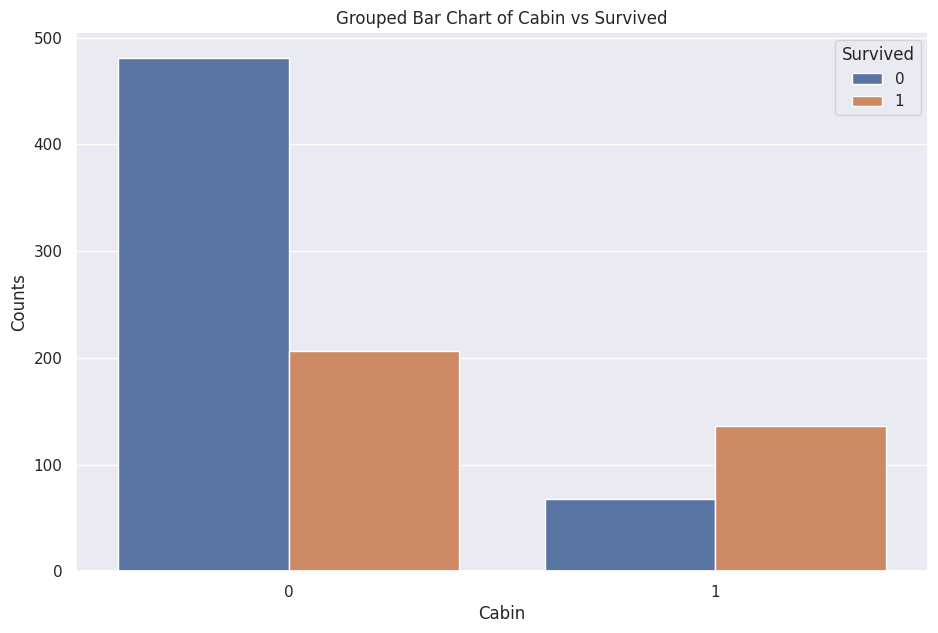

In [508]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each combination of Cabin and Survived
count_train_data = train_data.groupby(['Cabin', 'Survived']).size().reset_index(name='Counts')

# Grouped Bar Chart
sns.barplot(x='Cabin', y='Counts', hue='Survived', data=count_train_data)
plt.title('Grouped Bar Chart of Cabin vs Survived')
plt.xlabel('Cabin')
plt.ylabel('Counts')
plt.show()


  Embarked  Survival Rate
0        C       0.553571
1        Q       0.389610
2        S       0.339009


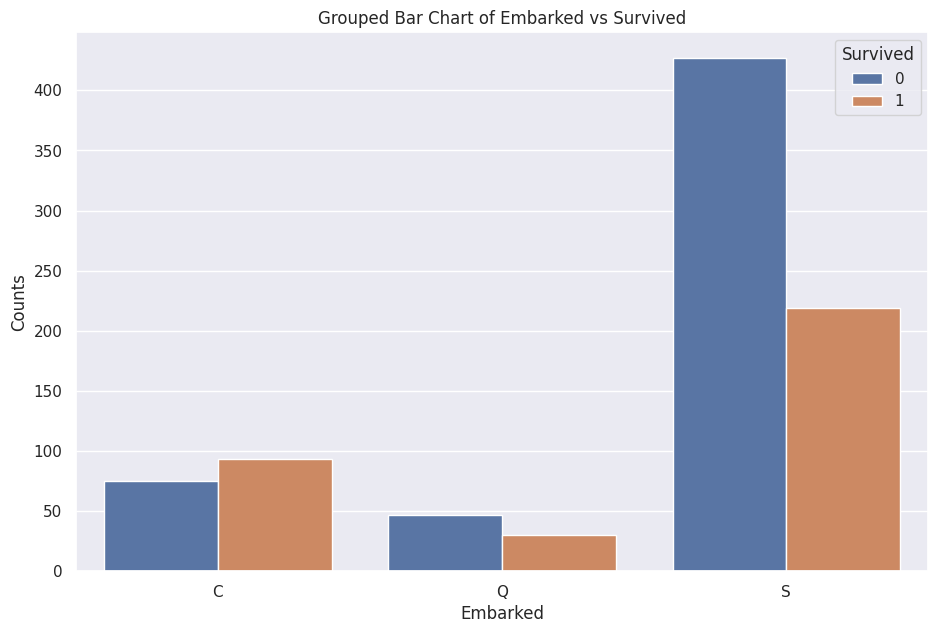

In [509]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_data is your DataFrame containing the Titanic data

# Count occurrences of each combination of Embarked and Survived
count_train_data = train_data.groupby(['Embarked', 'Survived']).size().reset_index(name='Counts')

# Calculate total passengers by Embarked port
total_passengers = count_train_data.groupby('Embarked')['Counts'].sum().reset_index(name='Total')

# Merge to get total passengers with the counts of survivors
merged_train_data = pd.merge(count_train_data, total_passengers, on='Embarked')

# Calculate the number of survivors
merged_train_data['Survivors'] = merged_train_data['Counts'].where(merged_train_data['Survived'] == 1, 0)

# Calculate survival rate
survival_rate = merged_train_data.groupby('Embarked').agg({'Survivors': 'sum', 'Total': 'first'}).reset_index()
survival_rate['Survival Rate'] = survival_rate['Survivors'] / survival_rate['Total']

# Print the survival rates
print(survival_rate[['Embarked', 'Survival Rate']])

# Plotting the grouped bar chart
sns.barplot(x='Embarked', y='Counts', hue='Survived', data=count_train_data)
plt.title('Grouped Bar Chart of Embarked vs Survived')
plt.xlabel('Embarked')
plt.ylabel('Counts')
plt.show()


In [510]:
value_counts = train_data['Embarked'].value_counts()
print(value_counts)

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [511]:
# Calculate the mean of the target variable for each category
mean_target = train_data.groupby('Embarked')['Survived'].mean()

# Map the encoded values back to the DataFrame
train_data['Embarked_Encoded'] = train_data['Embarked'].map(mean_target)

train_data = train_data.drop('Embarked', axis=1)
train_data

,Survived,Pclass,Sex,Age,Cabin,Data_Split,Fare_Per_Person,Family_Size_Encoded,Embarked_Encoded
0,0,3,male,22.0,0,train,3.6,0.552795,0.339009
1,1,1,female,38.0,1,train,35.6,0.552795,0.553571
2,1,3,female,26.0,0,train,7.9,0.303538,0.339009
3,1,1,female,35.0,1,train,26.6,0.552795,0.339009
4,0,3,male,35.0,0,train,8.0,0.303538,0.339009
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,train,13.0,0.303538,0.339009
887,1,1,female,19.0,1,train,30.0,0.303538,0.339009
888,0,3,female,NaN,0,train,5.9,0.724138,0.339009
889,1,1,male,26.0,1,train,30.0,0.303538,0.553571


In [512]:
# Calculate the mean of the target variable for each category
mean_target = test_data.groupby('Embarked')['Survived'].mean()

# Map the encoded values back to the DataFrame
test_data['Embarked_Encoded'] = test_data['Embarked'].map(mean_target)

test_data = test_data.drop('Embarked', axis=1)

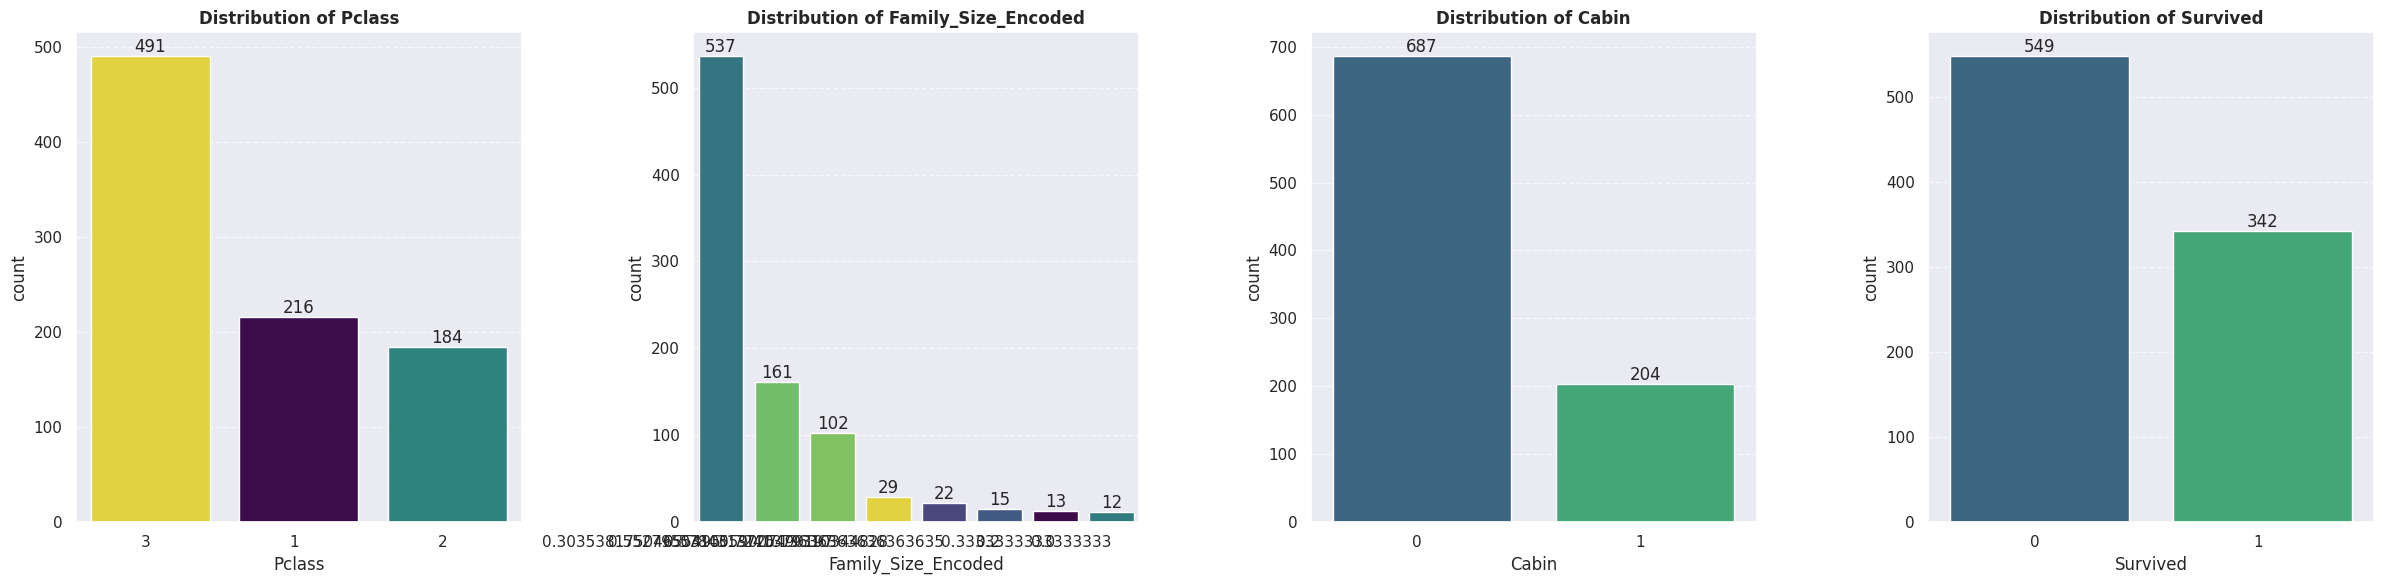

In [513]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create figure with specific size for readability
plt.figure(figsize=(24, 6))

# Columns to visualize
categorical_columns = ['Pclass', 'Family_Size_Encoded', 'Cabin', 'Survived']

# Create 1x4 grid of charts
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(1, 4, i)

    # Updated countplot to resolve FutureWarning
    chart = sns.countplot(
        data=train_data,
        x=column,
        hue=column,  # Assign x to hue
        legend=False,  # Remove legend
        order=train_data[column].value_counts().index,
        palette='viridis'  # Color palette
    )

    # Rotate and align the tick labels
    plt.xticks(rotation=0, ha='right')

    # Add title and adjust font
    plt.title(f'Distribution of {column}', fontsize=12, fontweight='bold')

    # Add count labels
    for container in chart.containers:
        chart.bar_label(container, label_type='edge')

    # Add grid lines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure tight layout to prevent overlap
plt.tight_layout()
plt.show()


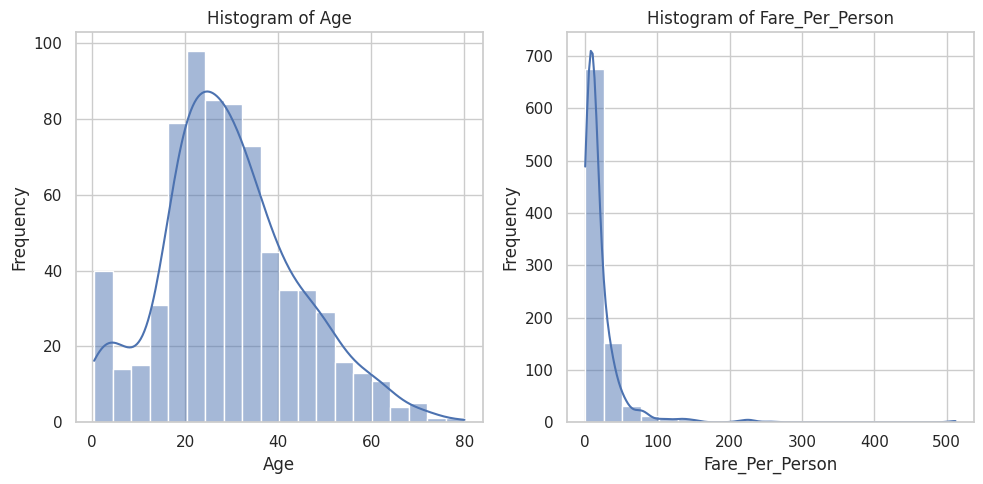

In [514]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the names of the columns you want to plot
columns_to_plot = ['Age', 'Fare_Per_Person']
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure with subplots
plt.figure(figsize=(10, 5))  # Adjusted width for better visibility in a horizontal layout

# Plot histograms for each specified column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 2, i)  # Create a 1x5 grid of subplots
    sns.histplot(train_data[column], bins=20, kde=True)  # kde=True adds a kernel density estimate
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Outliers

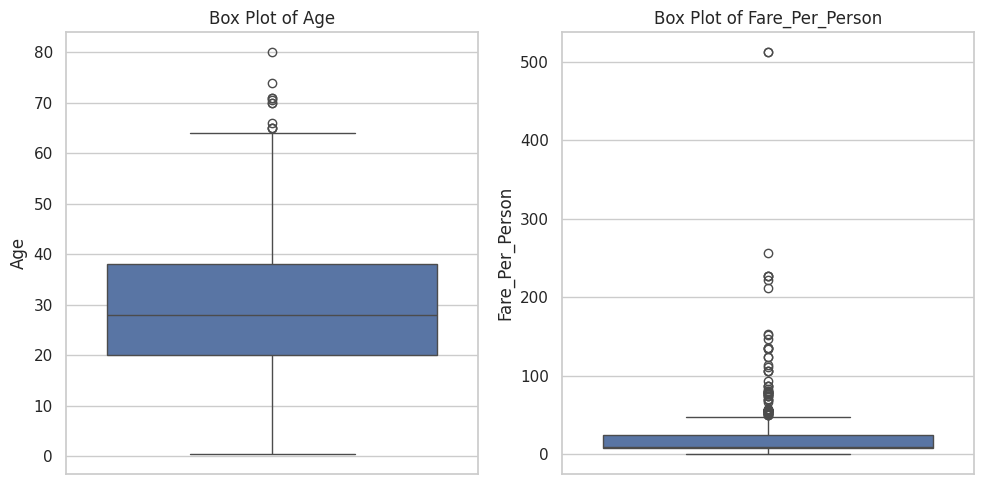

In [515]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the names of the columns you want to plot
columns_to_plot = ['Age', 'Fare_Per_Person']
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure with subplots
plt.figure(figsize=(10, 5))  # Adjusted width for better visibility in a horizontal layout

# Plot box plots for each specified column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 2, i)  # Create a 1x5 grid of subplots
    sns.boxplot(data=train_data, y=column)  # Use y=column for vertical box plots
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()


In [516]:
train_data['Age'].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

KNN Imputation of missing values

In [517]:
from sklearn.impute import KNNImputer

# Select Features: Choose relevant features for KNN imputation. You might want to exclude the Age column itself and any non-numeric columns.
features = train_data.drop(columns=['Survived', 'Pclass', 'Sex', 'Cabin', 'Embarked_Encoded', 'Data_Split', 'Family_Size_Encoded'])  # Exclude target and non-numeric columns

# Initialize KNN Imputer: Set up the KNN imputer with a specified number of neighbors (e.g., 5).
imputer = KNNImputer(n_neighbors=5)

# Impute the missing values in the Age column
train_data[['Age']] = imputer.fit_transform(features[['Age']])

print(train_data['Age'].isnull().sum())  # Should be 0 if all missing values were imputed

0


In [518]:
# Calculate Z-scores using .loc to avoid SettingWithCopyWarning
train_data.loc[:, 'Z-score_Age'] = stats.zscore(train_data['Age'])

# Define outliers based on Z-score threshold
outlier_condition = (train_data['Z-score_Age'] > 3) | (train_data['Z-score_Age'] < -3)
outliers = train_data[outlier_condition]

# Sort the outliers in ascending order and print only the outlier values of Age and their Z-scores
sorted_outliers = outliers[['Age', 'Z-score_Age']].sort_values(by='Age')
print(sorted_outliers)


      Age  Z-score_Age
745  70.0     3.101328
672  70.0     3.101328
116  70.5     3.139805
96   71.0     3.178283
493  71.0     3.178283
851  74.0     3.409146
630  80.0     3.870872


In [519]:
# Define the threshold for outliers (Custom partial removal of outlier based on Z-score)
threshold = 3.88

# Calculate the median of the Age column
median_value = train_data['Age'].median()

# Replace outliers with the median
train_data.loc[train_data['Z-score_Age'] > threshold, 'Age'] = median_value

In [520]:
train_data = train_data.drop('Z-score_Age', axis=1)

In [521]:
print(list(train_data.columns))

['Survived', 'Pclass', 'Sex', 'Age', 'Cabin', 'Data_Split', 'Fare_Per_Person', 'Family_Size_Encoded', 'Embarked_Encoded']


In [522]:
train_data.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
Cabin,0
Data_Split,0
Fare_Per_Person,0
Family_Size_Encoded,0
Embarked_Encoded,0


Text(0.5, 1.0, 'Boxplot for Age')

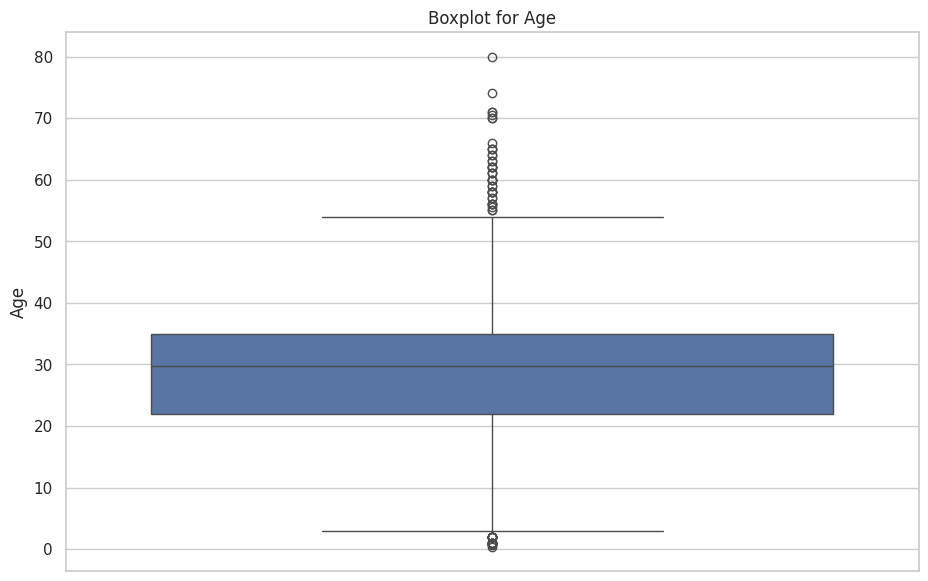

In [523]:
#Find outliers in the age column using box plot
sb.boxplot(train_data['Age'])
plt.title('Boxplot for Age')

In [524]:
from scipy import stats

# Calculate Z-scores
train_data['Z-score_Fare'] = stats.zscore(train_data['Fare_Per_Person'])

# Define outliers based on Z-score threshold
outlier_condition = (train_data['Z-score_Fare'] > 3) | (train_data['Z-score_Fare'] < -3)
outliers = train_data[outlier_condition]

# Sort the outliers in ascending order and print only the outlier values of Fare_Per_Person and their Z-scores
sorted_outliers = outliers[['Fare_Per_Person', 'Z-score_Fare']].sort_values(by='Fare_Per_Person')
print(sorted_outliers)


     Fare_Per_Person  Z-score_Fare
337            134.5      3.198774
325            135.6      3.229482
373            135.6      3.229482
269            135.6      3.229482
195            146.5      3.533771
708            151.6      3.676145
609            153.5      3.729186
730            211.3      5.342757
527            221.8      5.635880
380            227.5      5.795003
716            227.5      5.795003
557            227.5      5.795003
679            256.2      6.596205
258            512.3     13.745608
737            512.3     13.745608


In [525]:
# Define the threshold for outliers (Custom partial removal of outlier based on Z-score)
threshold = 5.34

# Calculate the median of the Fare_Per_Person column
median_value = train_data['Fare_Per_Person'].median()

# Replace outliers with the median
train_data.loc[train_data['Z-score_Fare'] > threshold, 'Fare_Per_Person'] = median_value


In [526]:
from scipy import stats

# Calculate Z-scores
train_data['Z-score_Fare'] = stats.zscore(train_data['Fare_Per_Person'])

# Define outliers based on Z-score threshold
outlier_condition = (train_data['Z-score_Fare'] > 3) | (train_data['Z-score_Fare'] < -3)
outliers = train_data[outlier_condition]

# Sort the outliers in ascending order and print only the outlier values of Fare_Per_Person and their Z-scores
sorted_outliers = outliers[['Fare_Per_Person', 'Z-score_Fare']].sort_values(by='Fare_Per_Person')
print(sorted_outliers)

     Fare_Per_Person  Z-score_Fare
310             83.2      3.146154
257             86.5      3.303703
504             86.5      3.303703
759             86.5      3.303703
520             93.5      3.637898
689            105.7      4.220352
779            105.7      4.220352
537            106.4      4.253772
306            110.9      4.468612
700            113.8      4.607064
118            123.8      5.084485
299            123.8      5.084485
337            134.5      5.595326
325            135.6      5.647843
373            135.6      5.647843
269            135.6      5.647843
195            146.5      6.168232
708            151.6      6.411717
609            153.5      6.502427


In [527]:
train_data = train_data.drop('Z-score_Fare', axis=1)

Text(0.5, 1.0, 'Box Plot for Fare')

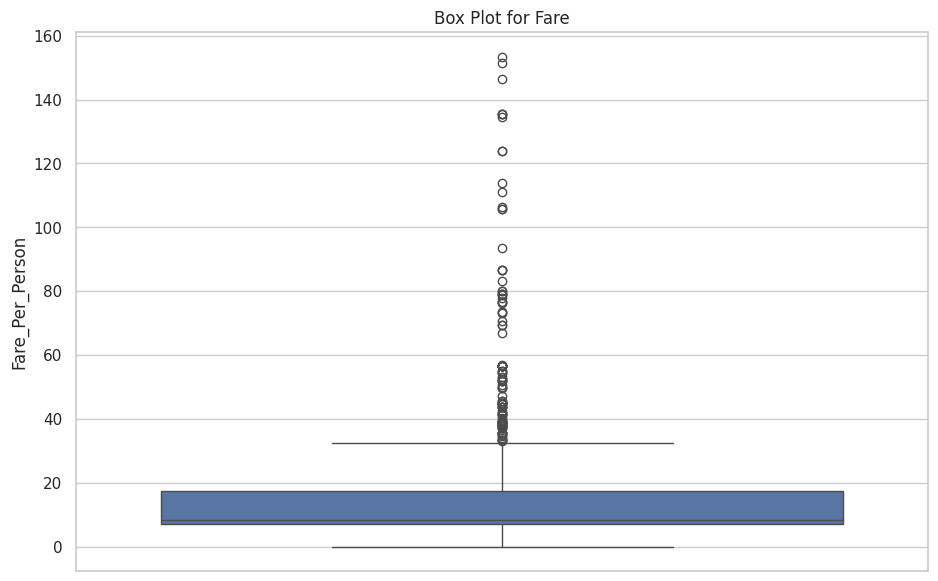

In [528]:
#Find if Fare has any outliers
sb.boxplot(train_data['Fare_Per_Person'])
plt.title('Box Plot for Fare')

### Joining data

In [529]:
df = pd.concat([train_data, test_data])
df

,Survived,Pclass,Sex,Age,Cabin,Data_Split,Fare_Per_Person,Family_Size_Encoded,Embarked_Encoded
0,0,3,male,22.0,0,train,3.6,0.552795,0.339009
1,1,1,female,38.0,1,train,35.6,0.552795,0.553571
2,1,3,female,26.0,0,train,7.9,0.303538,0.339009
3,1,1,female,35.0,1,train,26.6,0.552795,0.339009
4,0,3,male,35.0,0,train,8.0,0.303538,0.339009
...,...,...,...,...,...,...,...,...,...
413,0,3,male,NaN,0,test,8.0,0.268775,0.325926
414,1,1,female,39.0,1,test,108.9,0.268775,0.392157
415,0,3,male,38.5,0,test,7.2,0.268775,0.325926
416,0,3,male,NaN,0,test,8.0,0.268775,0.325926


### Encoding

In [530]:
df['Pclass'].unique()

array([3, 1, 2])

In [531]:
# Perform one-hot encoding
type_enc = pd.get_dummies(df['Pclass'], prefix='Pclass').astype(int)

# Rename the columns (if you want to change the prefix)
type_enc.columns = [col.replace('Pclass_', 'Class_') for col in type_enc.columns]

print(type_enc)

     Class_1  Class_2  Class_3
0          0        0        1
1          1        0        0
2          0        0        1
3          1        0        0
4          0        0        1
..       ...      ...      ...
413        0        0        1
414        1        0        0
415        0        0        1
416        0        0        1
417        0        0        1

[1309 rows x 3 columns]


In [532]:
type_enc_drop = pd.get_dummies(df['Pclass'], drop_first=True)
print(type_enc_drop)

         2      3
0    False   True
1    False  False
2    False   True
3    False  False
4    False   True
..     ...    ...
413  False   True
414  False  False
415  False   True
416  False   True
417  False   True

[1309 rows x 2 columns]


In [533]:
df_encoded = pd.concat([df, type_enc], axis=1)
df = df_encoded
df

,Survived,Pclass,Sex,Age,Cabin,Data_Split,Fare_Per_Person,Family_Size_Encoded,Embarked_Encoded,Class_1,Class_2,Class_3
0,0,3,male,22.0,0,train,3.6,0.552795,0.339009,0,0,1
1,1,1,female,38.0,1,train,35.6,0.552795,0.553571,1,0,0
2,1,3,female,26.0,0,train,7.9,0.303538,0.339009,0,0,1
3,1,1,female,35.0,1,train,26.6,0.552795,0.339009,1,0,0
4,0,3,male,35.0,0,train,8.0,0.303538,0.339009,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,3,male,NaN,0,test,8.0,0.268775,0.325926,0,0,1
414,1,1,female,39.0,1,test,108.9,0.268775,0.392157,1,0,0
415,0,3,male,38.5,0,test,7.2,0.268775,0.325926,0,0,1
416,0,3,male,NaN,0,test,8.0,0.268775,0.325926,0,0,1


In [534]:
df.drop('Pclass', axis=1, inplace=True)
df

,Survived,Sex,Age,Cabin,Data_Split,Fare_Per_Person,Family_Size_Encoded,Embarked_Encoded,Class_1,Class_2,Class_3
0,0,male,22.0,0,train,3.6,0.552795,0.339009,0,0,1
1,1,female,38.0,1,train,35.6,0.552795,0.553571,1,0,0
2,1,female,26.0,0,train,7.9,0.303538,0.339009,0,0,1
3,1,female,35.0,1,train,26.6,0.552795,0.339009,1,0,0
4,0,male,35.0,0,train,8.0,0.303538,0.339009,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
413,0,male,NaN,0,test,8.0,0.268775,0.325926,0,0,1
414,1,female,39.0,1,test,108.9,0.268775,0.392157,1,0,0
415,0,male,38.5,0,test,7.2,0.268775,0.325926,0,0,1
416,0,male,NaN,0,test,8.0,0.268775,0.325926,0,0,1


In [535]:
from sklearn.preprocessing import LabelEncoder

#Perform label encoding
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

In [536]:
#value_counts = df['Embarked'].value_counts()
#print(value_counts)

In [537]:
#from scipy.stats import pointbiserialr

# Calculate correlation for each Embarked
#correlation_map = {}
#for Embarked in df['Embarked'].unique():
#    correlation, _ = pointbiserialr(df['Survived'], df['Embarked'] == Embarked)
#    correlation_map[Embarked] = correlation

# Replace categories with correlation values
#df['Embarked_Encoded'] = df['Embarked'].map(correlation_map)

#df = df.drop('Embarked', axis=1)
#df

#### Data Split

In [538]:
# Split the data
X_train = df[df['Data_Split'] == 'train']
X_train.drop('Data_Split', axis=1, inplace=True)

X_test = df[df['Data_Split'] == 'test']
X_test.drop('Data_Split', axis=1, inplace=True)

/tmp/ipython-input-3162505073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('Data_Split', axis=1, inplace=True)
/tmp/ipython-input-3162505073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('Data_Split', axis=1, inplace=True)


In [539]:
print(list(X_train.columns))

['Survived', 'Sex', 'Age', 'Cabin', 'Fare_Per_Person', 'Family_Size_Encoded', 'Embarked_Encoded', 'Class_1', 'Class_2', 'Class_3']


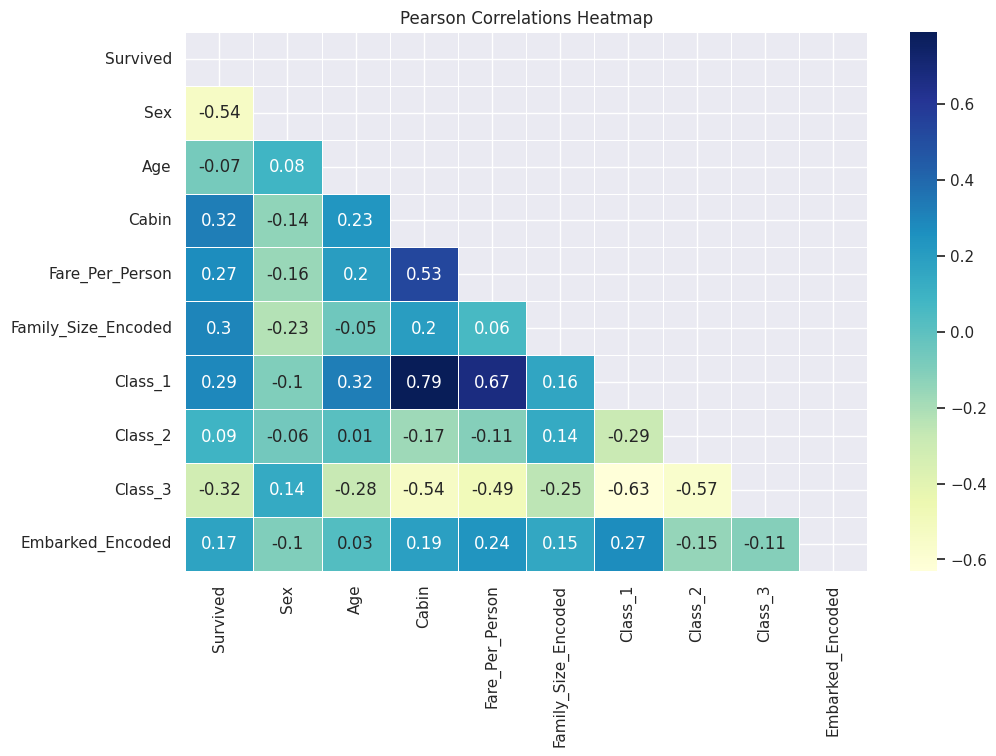

In [540]:
corr = X_train[['Survived', 'Sex', 'Age', 'Cabin', 'Fare_Per_Person', 'Family_Size_Encoded', 'Class_1', 'Class_2', 'Class_3', 'Embarked_Encoded']].corr()

corr_rounded = corr.round(2)  # Round to 2 decimal places

sns.set(rc={'figure.figsize':(11,7)})
sns.heatmap(corr_rounded,linewidths=.5, annot=True, cmap="YlGnBu",mask=np.triu(np.ones_like(corr_rounded, dtype=np.bool)))\
    .set_title("Pearson Correlations Heatmap");

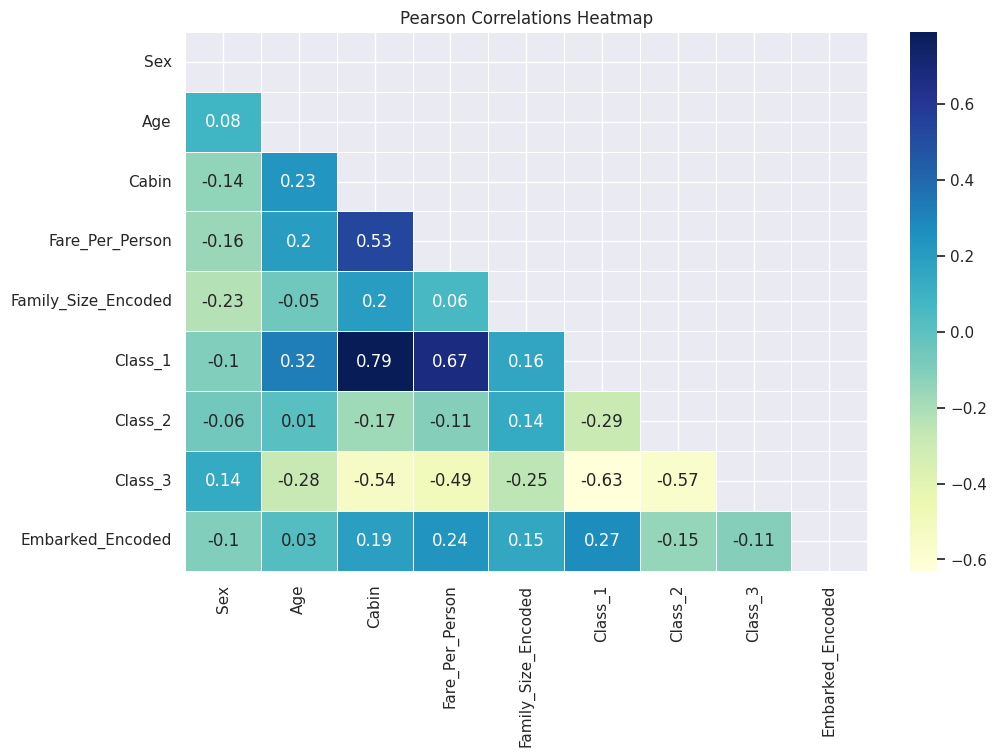

In [541]:
corr = X_train[['Sex', 'Age', 'Cabin', 'Fare_Per_Person', 'Family_Size_Encoded', 'Class_1', 'Class_2', 'Class_3', 'Embarked_Encoded']].corr()

corr_rounded = corr.round(2)  # Round to 2 decimal places

sns.set(rc={'figure.figsize':(11,7)})
sns.heatmap(corr_rounded,linewidths=.5, annot=True, cmap="YlGnBu",mask=np.triu(np.ones_like(corr_rounded, dtype=np.bool)))\
    .set_title("Pearson Correlations Heatmap");

Check for multicollinearity using VIF

In [542]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Assuming X_train is your DataFrame of features
def calculate_vif(X):
    # Exclude the 'Survived' column if it exists
    if 'Survived' in X.columns:
        X = X.drop(columns=['Survived'])

    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF
vif_df = calculate_vif(X_train)

# Display the VIF DataFrame
print(vif_df)


              Variable        VIF
0                  Sex   1.102970
1                  Age   1.166468
2                Cabin   2.728449
3      Fare_Per_Person   1.919268
4  Family_Size_Encoded   1.170794
5     Embarked_Encoded   1.124954
6              Class_1  18.039764
7              Class_2   9.276829
8              Class_3  21.691710


Observation: In general, a VIF value greater than 5 is considered to have multicollinearity.

## Scaling

In [543]:
### Perform Robust Scaling to handle outliers
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()
columns_to_scale = ['Age', 'Fare_Per_Person']

# Fit and transform the training data
X_train[columns_to_scale] = rob_scaler.fit_transform(X_train[columns_to_scale])

# Transform the test data
X_test[columns_to_scale] = rob_scaler.fit_transform(X_test[columns_to_scale])

X_train

/tmp/ipython-input-698201191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[columns_to_scale] = rob_scaler.fit_transform(X_train[columns_to_scale])
/tmp/ipython-input-698201191.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columns_to_scale] = rob_scaler.fit_transform(X_test[columns_to_scale])


,Survived,Sex,Age,Cabin,Fare_Per_Person,Family_Size_Encoded,Embarked_Encoded,Class_1,Class_2,Class_3
0,0,1,-0.592240,0,-0.456311,0.552795,0.339009,0,0,1
1,1,0,0.638529,1,2.650485,0.552795,0.553571,1,0,0
2,1,0,-0.284548,0,-0.038835,0.303538,0.339009,0,0,1
3,1,0,0.407760,1,1.776699,0.552795,0.339009,1,0,0
4,0,1,0.407760,0,-0.029126,0.303538,0.339009,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,0,1,-0.207624,0,0.456311,0.303538,0.339009,0,1,0
887,1,0,-0.823009,1,2.106796,0.303538,0.339009,1,0,0
888,0,0,0.000000,0,-0.233010,0.724138,0.339009,0,0,1
889,1,1,-0.284548,1,2.106796,0.303538,0.553571,1,0,0


In [544]:
X_train.describe()

,Survived,Sex,Age,Cabin,Fare_Per_Person,Family_Size_Encoded,Embarked_Encoded,Class_1,Class_2,Class_3
count,891.000000,891.000000,8.910000e+02,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.647587,2.153160e-16,0.228956,0.873895,0.383838,0.383838,0.242424,0.206510,0.551066
std,0.486592,0.477990,1.000155e+00,0.420397,2.034720,0.146416,0.083065,0.428790,0.405028,0.497665
min,0.000000,0.000000,-2.252240e+00,0.000000,-0.805825,0.000000,0.339009,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-5.922398e-01,0.000000,-0.106796,0.303538,0.339009,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.303538,0.339009,0.000000,0.000000,1.000000
75%,1.000000,1.000000,4.077602e-01,0.000000,0.893204,0.552795,0.389610,0.000000,0.000000,1.000000
max,1.000000,1.000000,3.869299e+00,1.000000,14.097087,0.724138,0.553571,1.000000,1.000000,1.000000


#### Save the data

In [545]:
# Save the DataFrame as a CSV file
X_train.to_csv('/content/drive/MyDrive/ML/titanic-ml-project/data/processed/train.csv', index=False)

# Save the DataFrame as a CSV file
X_test.to_csv('/content/drive/MyDrive/ML/titanic-ml-project/data/processed/test.csv', index=False)